<b>Author:</b> ...

<b>Contributors:</b> ...


<div class="alert alert-block alert-info">
Before you start running this notebook, make sure you are using the Hail Genomics Analysis Environment. To do so,
<br/>
    
<ul>
    <li>Click on the <b>cloud analysis environment</b> icon on the righthand side of the screen.</li>
    <li>Inside <b>Recommended environments</b>, select <b>Hail Genomics Analysis</b> which creates a cloud environment for your analyses.</li>
    <li>This analysis can be run with <b>low compute</b> (e.g. 2 workers with 4 CPUs, 15 GB of RAM).</li>
    <li>Click on <b>Next</b>.</li>
</ul>
    
</div>

<h1>Notebook Objectives</h1>

This notebook shows where the BAM files and manifest are, how to localize the manifest or a known BAM to your workspace bucket and active environment, and how to use the manifest to localize BAMs by the included paths.

<b>How to Use this Notebook...</b>

<b>As a tutorial:</b>

...

<b>As a resource:</b>

...

<h2>Relevant Information:</h2>

...

In [1]:
import pandas as pd
import numpy as np
import pysam
import os
import ast

## Participants who withdrew between CDR v7 and v8 

### The following participants were found to have withdrawn from the AoU Research Program between the releases of CDR v7 and v8. We list them here and filter them out of summaries and analyses.

In [89]:
withdrawn_participants = [
 1156403,
 1174276,
 1174790,
 1206898,
 1229951,
 1363556,
 1471884,
 1605046,
 1623343,
 1728436,
 1743479,
 1815174,
 1837737,
 1907543,
 1918452,
 1920682,
 1933591,
 1950104,
 1964615,
 2022931,
 2062383,
 2067270
]

## Short read metrics

In [95]:
import pandas
import os

# This query represents dataset "Short reads" for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_37633348_person_sql = """
    SELECT
        person.person_id,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as date_of_birth,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id  
    WHERE
        person.PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                person_id 
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
            WHERE
                has_whole_genome_variant = 1 ) )"""

dataset_37633348_person_df = pandas.read_gbq(
    dataset_37633348_person_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_37633348_person_df.head(5)

# This query represents dataset "Short reads" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_37633348_survey_sql = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (SELECT
                DISTINCT concept_id                         
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c                         
            JOIN
                (SELECT
                    CAST(cr.id as string) AS id                               
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr                               
                WHERE
                    concept_id IN (1586134)                               
                    AND domain_id = 'SURVEY') a 
                    ON (c.path like CONCAT('%', a.id, '.%'))                         
            WHERE
                domain_id = 'SURVEY'                         
                AND type = 'PPI'                         
                AND subtype = 'QUESTION')
        )  
        AND (
            answer.PERSON_ID IN (SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (SELECT
                    person_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                WHERE
                    has_whole_genome_variant = 1 ) )
        )"""

dataset_37633348_survey_df = pandas.read_gbq(
    dataset_37633348_survey_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_37633348_survey_df.head(5)
import pandas
import os

# This query represents dataset "Short reads" for domain "zip_code_socioeconomic" and was generated for All of Us Controlled Tier Dataset v7
dataset_37633348_zip_code_socioeconomic_sql = """
    SELECT
        observation.person_id,
        observation.observation_datetime,
        zip_code.zip3_as_string as zip_code,
        zip_code.fraction_assisted_income as assisted_income,
        zip_code.fraction_high_school_edu as high_school_education,
        zip_code.median_income,
        zip_code.fraction_no_health_ins as no_health_insurance,
        zip_code.fraction_poverty as poverty,
        zip_code.fraction_vacant_housing as vacant_housing,
        zip_code.deprivation_index,
        zip_code.acs as american_community_survey_year 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.zip3_ses_map` zip_code 
    JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.observation` observation 
            ON CAST(SUBSTR(observation.value_as_string, 0, STRPOS(observation.value_as_string, '*') - 1) AS INT64) = zip_code.zip3  
    WHERE
        observation.PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                person_id 
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
            WHERE
                has_whole_genome_variant = 1 ) ) 
        AND observation_source_concept_id = 1585250 
        AND observation.value_as_string NOT LIKE 'Res%'"""

dataset_37633348_zip_code_socioeconomic_df = pandas.read_gbq(
    dataset_37633348_zip_code_socioeconomic_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_37633348_zip_code_socioeconomic_df.head(5)

Downloading:   0%|          | 0/245388 [00:00<?, ?rows/s]

Downloading:   0%|          | 0/5016437 [00:00<?, ?rows/s]

Downloading:   0%|          | 0/245224 [00:00<?, ?rows/s]

,person_id,observation_datetime,zip_code,assisted_income,high_school_education,median_income,no_health_insurance,poverty,vacant_housing,deprivation_index,american_community_survey_year
0,1629353,2020-03-05 17:08:33+00:00,014**,12.575548,89.827996,76472.899608,2.848565,10.800381,7.986200,0.263013,2017
1,2364725,2019-06-19 15:36:44+00:00,016**,22.527143,84.993562,50685.199639,3.221594,21.453950,9.305993,0.355175,2017
2,9549663,2021-06-02 14:16:16+00:00,019**,12.889697,90.894584,81093.221321,2.948661,9.679384,6.108289,0.251716,2017
3,4506281,2022-02-15 18:27:27+00:00,019**,12.889697,90.894584,81093.221321,2.948661,9.679384,6.108289,0.251716,2017
4,1177025,2021-10-04 13:57:50+00:00,019**,12.889697,90.894584,81093.221321,2.948661,9.679384,6.108289,0.251716,2017


In [96]:
if not os.path.exists("genomic_metrics.tsv"):
    !gsutil -u $GOOGLE_PROJECT cp gs://fc-aou-datasets-controlled/v7/wgs/short_read/snpindel/aux/qc/genomic_metrics.tsv .
    
sr_metrics = pd.read_table('genomic_metrics.tsv')

In [97]:
sr_metrics = sr_metrics[sr_metrics['research_id'].isin(dataset_37633348_person_df['person_id'])]

In [98]:
sr_metrics

,research_id,sample_source,site_id,sex_at_birth,dragen_sex_ploidy,mean_coverage,genome_coverage,aou_hdr_coverage,dragen_contamination,aligned_q30_bases,verify_bam_id2_contamination,biosample_collection_date
0,1000004,Whole Blood,bi,M,XY,44.15,96.95,99.67,0.0,1.494380e+11,1.019330e-05,2019-07-26
1,1000033,Whole Blood,bi,M,XY,37.45,96.49,99.46,0.0,1.227449e+11,1.076750e-05,2019-08-06
2,1000039,Whole Blood,bi,F,XX,35.60,95.61,99.51,0.0,1.158729e+11,2.242160e-05,2020-02-11
3,1000042,Whole Blood,bi,M,XY,41.71,96.72,99.37,0.0,1.329559e+11,6.198400e-06,2019-06-19
4,1000045,Whole Blood,uw,F,XX,40.73,96.74,99.97,0.0,1.337420e+11,1.591560e-04,2020-02-27
...,...,...,...,...,...,...,...,...,...,...,...,...
245389,9998987,Whole Blood,bi,M,XY,42.62,96.84,99.58,0.0,1.375518e+11,4.954170e-06,2021-11-03
245390,9999351,Whole Blood,bcm,F,XX,36.29,96.28,99.83,0.0,1.270510e+11,1.908060e-06,2022-03-30
245391,9999412,Whole Blood,bcm,M,XY,37.97,96.46,99.16,0.0,1.206260e+11,3.692460e-06,2021-10-19
245392,9999653,Whole Blood,bcm,F,XX,36.36,96.29,99.86,0.0,1.303830e+11,7.601530e-09,2022-01-26


In [105]:
sr_num_samples = f'{len(dataset_37633348_person_df):,}'
sr_num_samples

'245,388'

In [100]:
sr_cov = f'{sr_metrics.mean_coverage.mean():.1f} +/- {sr_metrics.mean_coverage.std():.1f}'
sr_cov

'39.0 +/- 4.3'

In [106]:
sr_female = sr_metrics.query('sex_at_birth == "F"').count()['research_id']
sr_male = sr_metrics.query('sex_at_birth == "M"').count()['research_id']
sr_unknown = len(dataset_37633348_person_df) - sr_female - sr_male

sr_female = f'{sr_female:,}'
sr_male = f'{sr_male:,}'
sr_unknown = f'{sr_unknown:,}'

(sr_female, sr_male, sr_unknown)

('147,047', '95,489', '2,852')

In [107]:
!gsutil -u $GOOGLE_PROJECT cat gs://fc-aou-datasets-controlled/v7/wgs/cram/manifest.csv | head -n 2

person_id,cram_uri,cram_index_uri
1000004,gs://fc-aou-datasets-controlled/pooled/wgs/cram/v6_base/wgs_1000004.cram,gs://fc-aou-datasets-controlled/pooled/wgs/cram/v6_base/wgs_1000004.cram.crai


In [108]:
sr_read_lengths = !gsutil -u $GOOGLE_PROJECT cat gs://fc-aou-datasets-controlled/pooled/wgs/cram/v6_base/wgs_1000004.cram | samtools view | head -n 100 | tail -n1 | awk '{ print length($10) }'
    

In [109]:
sr_read_lengths

['151']

In [110]:
sr_read_length = sr_read_lengths[0]
sr_read_length

'151'

## Long read metrics

In [111]:
if not os.path.exists('sample-hg38.tsv'):
    !gsutil cp $WORKSPACE_BUCKET/datatables/sample-hg38.tsv sample-hg38.tsv

In [112]:
f = pd.read_table('sample-hg38.tsv')
f

,entity:sample-hg38_id,AoU_phase,DRC_inferred_sex_info,GC,aligned_bai,aligned_bam,alignment_metrics,biobank_id,contamination_est,contamination_est_correct,...,pbsv_vcf,registration_time,sex,sniffles_counts,sniffles_phased_snf,sniffles_phased_tbi,sniffles_phased_vcf,sniffles_snf,sniffles_tbi,sniffles_vcf
0,1000513,1,"{""is_sex_concordant"":""true"",""scaled_x_dp_mean""...",BCM,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,"{""Reads_Q10"":6125874,""Reads_Q12"":5865746,""Read...",A236725162,0.005494,0.005494,...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,08/23/23 17:39:18,F,"{""BND"":71,""DEL"":11718,""DUP"":9,""INS"":15387,""INV...",gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...
1,1000920,1,"{""is_sex_concordant"":""true"",""scaled_x_dp_mean""...",BCM,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,"{""Reads_Q10"":7588703,""Reads_Q12"":7278693,""Read...",A460881279,0.005714,0.005714,...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,08/23/23 17:39:18,F,"{""BND"":64,""DEL"":11751,""DUP"":13,""INS"":15533,""IN...",gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...
2,1001399,1,"{""is_sex_concordant"":""true"",""scaled_x_dp_mean""...",BCM,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,"{""Reads_Q10"":5423515,""Reads_Q12"":5191443,""Read...",A729517766,0.005352,0.005352,...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,08/23/23 17:39:18,M,"{""BND"":71,""DEL"":11841,""DUP"":7,""INS"":15397,""INV...",gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...
3,1001980,1,"{""is_sex_concordant"":""true"",""scaled_x_dp_mean""...",BCM,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,"{""Reads_Q10"":7206743,""Reads_Q12"":6916539,""Read...",A482111054,0.005254,0.005254,...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,08/23/23 17:39:18,M,"{""BND"":92,""DEL"":11313,""DUP"":8,""INS"":14942,""INV...",gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...
4,1002322,1,"{""is_sex_concordant"":""true"",""scaled_x_dp_mean""...",BCM,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,"{""Reads_Q10"":7663747,""Reads_Q12"":7407035,""Read...",A569803320,0.004912,0.004925,...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,08/23/23 17:39:18,F,"{""BND"":87,""DEL"":11806,""DUP"":5,""INS"":15557,""INV...",gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...
5,1002826,1,"{""is_sex_concordant"":""true"",""scaled_x_dp_mean""...",BCM,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,gs://fc-secure-40105462-ef9c-4da2-a868-0726a31...,"{""Reads_Q10"":7099014,""Reads_Q12"":6831066,

In [113]:
f['entity:sample-hg38_id'].astype(int).isin(withdrawn_participants).sum()

0

In [114]:
ont_cov_mean = f['coverage'].mean()
ont_cov_std = f['coverage'].std()

ont_cov = f'{ont_cov_mean:.1f} +/- {ont_cov_std:.1f}'

In [115]:
ont_rl_mean = f['alignment_metrics'].apply(lambda x: ast.literal_eval(x)).apply(pd.Series)['median_read_length'].mean()
ont_rl_std = f['alignment_metrics'].apply(lambda x: ast.literal_eval(x)).apply(pd.Series)['median_read_length'].std()

ont_read_length = f'{ont_rl_mean:,.0f} +/- {ont_rl_std:,.0f}'
ont_read_length

'14,867 +/- 795'

In [116]:
if not os.path.exists('auxiliary_metrics.GRCh38.tsv'):
    !gsutil -u $GOOGLE_PROJECT cp gs://fc-aou-datasets-controlled/v7/wgs/long_read/aux/auxiliary_metrics.GRCh38.tsv .

In [117]:
lr_metrics = pd.read_table('auxiliary_metrics.GRCh38.tsv')

In [118]:
lr_metrics = lr_metrics[~lr_metrics['research_id'].astype(int).isin(withdrawn_participants)]

In [119]:
lr_metrics

,research_id,mosdepth_cov,aligned_frac_bases,aligned_num_bases,aligned_num_reads,aligned_read_length_N50,aligned_read_length_median,aligned_read_length_mean,aligned_read_length_stdev,average_identity,median_identity,dvp_ft_pass_snp_cnt,pbsv_nonBND_50bpSV_cnt,snf2_nonBND_50bpSV_cnt
0,1000151,7.82,1.0,2.405917e+10,1430579.0,18313.0,17430.0,17021.8,4959.5,98.7,99.6,3796010.0,27321.0,24094.0
1,1000513,6.98,1.0,2.149734e+10,1393583.0,17125.0,16434.0,15608.5,4656.1,98.7,99.6,3529709.0,26269.0,22598.0
2,1000920,7.92,1.0,2.439392e+10,1363945.0,19251.0,18248.0,18098.0,5257.7,98.8,99.6,3816121.0,27161.0,24201.0
3,1001399,6.72,1.0,2.068706e+10,1138731.0,18782.0,18207.0,18384.7,3366.1,98.7,99.6,3479511.0,27159.0,24175.0
4,1001980,7.74,1.0,2.378861e+10,1192897.0,20451.0,19649.0,20242.1,4391.4,98.6,99.6,3477270.0,26266.0,22977.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,8838544,7.60,1.0,2.338911e+10,1479278.0,17465.0,16588.0,15996.1,5055.1,98.8,99.6,3818604.0,27702.0,24670.0
1023,9322885,7.75,1.0,2.388734e+10,1369175.0,18031.0,17448.0,17658.0,3562.1,98.6,99.5,3763557.0,26994.0,23767.0
1024,9526330,8.92,1.0,2.740756e+10,1510283.0,18976.0,18027.0,18382.0,4849.0,98.7,99.6,3939896.0,27702.0,25023.0
1025,9674245,6.80,1.0,2.095856e+10,1322374.0,17459.0,16675.0,16014.3,4940.8,98.8,99.7,3496310.0,26254.0,22618.0


In [130]:
sr_metrics[sr_metrics['research_id'].isin(lr_metrics['research_id'])]['sex_at_birth'].value_counts(dropna=False)

sex_at_birth
F      708
M      289
NaN      8
Name: count, dtype: int64

In [134]:
lr_female = sr_metrics[sr_metrics['research_id'].isin(lr_metrics.research_id)].query('sex_at_birth == "F"').count()['research_id']
lr_male = sr_metrics[sr_metrics['research_id'].isin(lr_metrics.research_id)].query('sex_at_birth == "M"').count()['research_id']
lr_unknown = len(lr_metrics) - lr_female - lr_male

(lr_female, lr_male, lr_unknown)

(708, 289, 8)

In [137]:
lr_num_samples = f'{lr_metrics.shape[0]:,}'
lr_num_samples

'1,005'

In [138]:
lr_cov = f'{lr_metrics.mosdepth_cov.mean():.1f} +/- {lr_metrics.mosdepth_cov.std():.1f}'
lr_cov

'8.0 +/- 1.3'

In [139]:
lr_read_length = f'{lr_metrics.aligned_read_length_mean.mean():,.0f} +/- {lr_metrics.aligned_read_length_mean.std():,.0f}'
lr_read_length

'17,415 +/- 1,105'

In [140]:
!gsutil -u $GOOGLE_PROJECT cat gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/1000151/report_map.txt | column -t

Assembly                    1000151.p_ctg  1000151.bp.hap1.p_ctg  1000151.bp.hap2.p_ctg
#_contigs_(gt_0_bp)         27151          32969                  28514
#_contigs_(gt_1000_bp)      27147          32965                  28513
#_contigs_(gt_5000_bp)      27141          32959                  28511
#_contigs_(gt_10000_bp)     27141          32959                  28511
#_contigs_(gt_25000_bp)     26992          32452                  28380
#_contigs_(gt_50000_bp)     21608          22856                  22436
Total_length_(gt_0_bp)      3742602783     3129680717             2909720507
Total_length_(gt_1000_bp)   3742599984     3129677918             2909719789
Total_length_(gt_5000_bp)   3742591626     3129669560             2909716419
Total_length_(gt_10000_bp)  3742591626     3129669560             2909716419
Total_length_(gt_25000_bp)  3739140140     3118623741             2906717820
Total_length_(gt_50000_bp)  3526738227     2745322344             2668983429
#_contigs         

In [141]:
!gsutil -u $GOOGLE_PROJECT ls gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/*/report_map.txt | head

gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/1000151/report_map.txt
gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/1000513/report_map.txt
gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/1000920/report_map.txt
gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/1001399/report_map.txt
gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/1001980/report_map.txt
gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/1002322/report_map.txt
gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/1002826/report_map.txt
gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/1004266/report_map.txt
gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/1005038/report_map.txt
gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/1005444/report_map.txt
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken p

In [142]:
if not os.path.exists('full_report_map.txt'):
    !gcloud storage cat --billing-project=${GOOGLE_PROJECT} gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/hifiasm/*/report_map.txt > full_report_map.txt
    

In [143]:
hap1_num = !cat full_report_map.txt | grep '#_contigs' | grep -v 'gt_' | awk '{ print $3 }'
hap2_num = !cat full_report_map.txt | grep '#_contigs' | grep -v 'gt_' | awk '{ print $4 }'

In [144]:
hap1_num_mean = f'{np.mean([int(a) for a in hap1_num]):,.0f} +/- {np.std([int(a) for a in hap1_num]):,.0f}'
hap1_num_mean

'28,174 +/- 4,680'

In [145]:
hap2_num_mean = f'{np.mean([int(a) for a in hap2_num]):,.0f} +/- {np.std([int(a) for a in hap2_num]):,.0f}'
hap2_num_mean

'24,926 +/- 3,727'

In [146]:
hap1_n50 = !cat full_report_map.txt | grep '^N50' | awk '{ print $3 }'
hap2_n50 = !cat full_report_map.txt | grep '^N50' | awk '{ print $4 }'

In [147]:
hap1_n50_median = f'{np.median([int(a) for a in hap1_n50]):,.0f}'
hap1_n50_median

'124,757'

In [148]:
hap2_n50_median = f'{np.median([int(a) for a in hap2_n50]):,.0f}'
hap2_n50_median

'128,424'

## Load controlled tier datasets (short read participants)

In [149]:
# This query represents dataset "Short reads" for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_74841393_person_sql = """
    SELECT
        person.person_id,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as date_of_birth,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id  
    WHERE
        person.PERSON_ID IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_whole_genome_variant = 1 
                ) 
            )"""

dataset_74841393_person_df = pd.read_gbq(
    dataset_74841393_person_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_74841393_person_df.head(5)

# This query represents dataset "Short reads" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_74841393_survey_sql = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (
                SELECT
                    DISTINCT concept_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                JOIN
                    (
                        select
                            cast(cr.id as string) as id 
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                        WHERE
                            concept_id IN (
                                1586134
                            ) 
                            AND domain_id = 'SURVEY'
                    ) a 
                        ON (
                            c.path like CONCAT('%',
                        a.id,
                        '.%')) 
                    WHERE
                        domain_id = 'SURVEY' 
                        AND type = 'PPI' 
                        AND subtype = 'QUESTION'
                    )
            )  
            AND (
                answer.PERSON_ID IN (
                    SELECT
                        distinct person_id  
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                    WHERE
                        cb_search_person.person_id IN (
                            SELECT
                                person_id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                            WHERE
                                has_whole_genome_variant = 1 
                        ) 
                    )
            )"""

dataset_74841393_survey_df = pd.read_gbq(
    dataset_74841393_survey_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_74841393_survey_df.head(5)

# This query represents dataset "Short reads" for domain "zip_code_socioeconomic" and was generated for All of Us Controlled Tier Dataset v7
dataset_74841393_zip_code_socioeconomic_sql = """
    SELECT
        observation.person_id,
        observation.observation_datetime,
        zip_code.zip3_as_string as zip_code,
        zip_code.fraction_assisted_income as assisted_income,
        zip_code.fraction_high_school_edu as high_school_education,
        zip_code.median_income,
        zip_code.fraction_no_health_ins as no_health_insurance,
        zip_code.fraction_poverty as poverty,
        zip_code.fraction_vacant_housing as vacant_housing,
        zip_code.deprivation_index,
        zip_code.acs as american_community_survey_year 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.zip3_ses_map` zip_code 
    JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.observation` observation 
            ON CAST(SUBSTR(observation.value_as_string,
        0,
        STRPOS(observation.value_as_string,
        '*') - 1) AS INT64) = zip_code.zip3  
    WHERE
        observation.PERSON_ID IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_whole_genome_variant = 1 
                ) 
            ) 
            AND observation_source_concept_id = 1585250 
            AND observation.value_as_string NOT LIKE 'Res%'"""

dataset_74841393_zip_code_socioeconomic_df = pd.read_gbq(
    dataset_74841393_zip_code_socioeconomic_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_74841393_zip_code_socioeconomic_df.head(5)

Downloading:   0%|          | 0/245388 [00:00<?, ?rows/s]

Downloading:   0%|          | 0/5016437 [00:00<?, ?rows/s]

Downloading:   0%|          | 0/245224 [00:00<?, ?rows/s]

,person_id,observation_datetime,zip_code,assisted_income,high_school_education,median_income,no_health_insurance,poverty,vacant_housing,deprivation_index,american_community_survey_year
0,1451004,2019-07-11 16:18:06+00:00,013**,15.136892,91.698814,57851.491240,2.861232,11.465418,10.714181,0.287093,2017
1,6641619,2021-08-09 18:20:58+00:00,018**,13.638782,88.950838,88796.704011,2.961726,10.277005,4.678395,0.251301,2017
2,1448204,2019-02-25 17:28:05+00:00,018**,13.638782,88.950838,88796.704011,2.961726,10.277005,4.678395,0.251301,2017
3,4498182,2021-12-20 00:59:06+00:00,019**,12.889697,90.894584,81093.221321,2.948661,9.679384,6.108289,0.251716,2017
4,1702117,2020-01-22 15:26:54+00:00,019**,12.889697,90.894584,81093.221321,2.948661,9.679384,6.108289,0.251716,2017


## Load controlled tier datasets (short read participants with EHRs)

In [153]:
# This query represents dataset "Short reads, basic info" for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_00296524_person_sql = """
    SELECT
        person.person_id,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as date_of_birth,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id  
    WHERE
        person.PERSON_ID IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_whole_genome_variant = 1 
                ) 
                AND cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_ehr_data = 1 
                ) 
            )"""

dataset_00296524_person_df = pd.read_gbq(
    dataset_00296524_person_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_00296524_person_df.head(5)

Downloading:   0%|          | 0/206173 [00:00<?, ?rows/s]

,person_id,gender_concept_id,gender,date_of_birth,race_concept_id,race,ethnicity_concept_id,ethnicity,sex_at_birth_concept_id,sex_at_birth
0,1557911,1177221,I prefer not to answer,1979-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,46273637,Intersex
1,2028643,45880669,Male,1976-06-15 00:00:00+00:00,903096,PMI: Skip,903096,PMI: Skip,46273637,Intersex
2,1896764,1585843,Gender Identity: Additional Options,1965-06-15 00:00:00+00:00,2100000001,None Indicated,38003563,Hispanic or Latino,46273637,Intersex
3,1547381,903096,PMI: Skip,1983-06-15 00:00:00+00:00,2100000001,None Indicated,38003563,Hispanic or Latino,46273637,Intersex
4,3008331,45880669,Male,1997-06-15 00:00:00+00:00,2100000001,None Indicated,38003563,Hispanic or Latino,46273637,Intersex


In [154]:
dataset_00296524_person_df = dataset_00296524_person_df[~dataset_00296524_person_df['person_id'].astype(int).isin(withdrawn_participants)]

In [155]:
dataset_00296524_person_df.groupby('race').agg('count')

,person_id,gender_concept_id,gender,date_of_birth,race_concept_id,ethnicity_concept_id,ethnicity,sex_at_birth_concept_id,sex_at_birth
race,,,,,,,,,
Asian,5780,5780,5780,5780,5780,5780,5780,5780,5780
Black or African American,40822,40822,40822,40822,40822,40822,40822,40822,40822
I prefer not to answer,1211,1211,1211,1211,1211,1211,1211,1211,1211
Middle Eastern or North African,1157,1157,1157,1157,1157,1157,1157,1157,1157
More than one population,3532,3532,3532,3532,3532,3532,3532,3532,3532
Native Hawaiian or Other Pacific Islander,222,222,222,222,222,222,222,222,222
None Indicated,33664,33664,33664,33664,33664,33664,33664,33664,33664
None of these,2099,2099,2099,2099,2099,2099,2099,2099,2099
PMI: Skip,4579,4579,4579,4579,4579,4579,4579,4579,4579


## Load controlled tier datasets (long read participants with EHRs)

In [156]:
# This query represents dataset "Long reads, basic info, socioeconomic status" for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_95752237_person_sql = """
    SELECT
        person.person_id,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as date_of_birth,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id  
    WHERE
        person.PERSON_ID IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_whole_genome_variant = 1 
                ) 
                AND cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_lr_whole_genome_variant = 1 
                ) 
                AND cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_ehr_data = 1 
                ) 
            )"""

dataset_95752237_person_df = pd.read_gbq(
    dataset_95752237_person_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

# This query represents dataset "Long reads, basic info, socioeconomic status" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_95752237_survey_sql = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (
                SELECT
                    DISTINCT concept_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                JOIN
                    (
                        select
                            cast(cr.id as string) as id 
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                        WHERE
                            concept_id IN (
                                1586134
                            ) 
                            AND domain_id = 'SURVEY'
                    ) a 
                        ON (
                            c.path like CONCAT('%',
                        a.id,
                        '.%')) 
                    WHERE
                        domain_id = 'SURVEY' 
                        AND type = 'PPI' 
                        AND subtype = 'QUESTION'
                    )
            )  
            AND (
                answer.PERSON_ID IN (
                    SELECT
                        distinct person_id  
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                    WHERE
                        cb_search_person.person_id IN (
                            SELECT
                                person_id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                            WHERE
                                has_whole_genome_variant = 1 
                        ) 
                        AND cb_search_person.person_id IN (
                            SELECT
                                person_id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                            WHERE
                                has_lr_whole_genome_variant = 1 
                        ) 
                        AND cb_search_person.person_id IN (
                            SELECT
                                person_id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                            WHERE
                                has_ehr_data = 1 
                        ) 
                    )
                )"""

# dataset_95752237_survey_df = pd.read_gbq(
#     dataset_95752237_survey_sql,
#     dialect="standard",
#     use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
#     progress_bar_type="tqdm_notebook")

# This query represents dataset "Long reads, basic info, socioeconomic status" for domain "zip_code_socioeconomic" and was generated for All of Us Controlled Tier Dataset v7
dataset_95752237_zip_code_socioeconomic_sql = """
    SELECT
        observation.person_id,
        observation.observation_datetime,
        zip_code.zip3_as_string as zip_code,
        zip_code.fraction_assisted_income as assisted_income,
        zip_code.fraction_high_school_edu as high_school_education,
        zip_code.median_income,
        zip_code.fraction_no_health_ins as no_health_insurance,
        zip_code.fraction_poverty as poverty,
        zip_code.fraction_vacant_housing as vacant_housing,
        zip_code.deprivation_index,
        zip_code.acs as american_community_survey_year 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.zip3_ses_map` zip_code 
    JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.observation` observation 
            ON CAST(SUBSTR(observation.value_as_string,
        0,
        STRPOS(observation.value_as_string,
        '*') - 1) AS INT64) = zip_code.zip3  
    WHERE
        observation.PERSON_ID IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_whole_genome_variant = 1 
                ) 
                AND cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_lr_whole_genome_variant = 1 
                ) 
                AND cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_ehr_data = 1 
                ) 
            ) 
            AND observation_source_concept_id = 1585250 
            AND observation.value_as_string NOT LIKE 'Res%'"""

dataset_95752237_zip_code_socioeconomic_df = pd.read_gbq(
    dataset_95752237_zip_code_socioeconomic_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

Downloading:   0%|          | 0/985 [00:00<?, ?rows/s]

Downloading:   0%|          | 0/985 [00:00<?, ?rows/s]

In [177]:
dataset_95752237_person_df = dataset_95752237_person_df[~dataset_95752237_person_df['person_id'].astype(int).isin(withdrawn_participants)]

In [179]:
dataset_95752237_person_df

,person_id,gender_concept_id,gender,date_of_birth,race_concept_id,race,ethnicity_concept_id,ethnicity,sex_at_birth_concept_id,sex_at_birth
0,1794450,45878463,Female,1988-06-15 00:00:00+00:00,2000000008,More than one population,38003564,Not Hispanic or Latino,903096,PMI: Skip
1,1796001,903096,PMI: Skip,1954-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,903096,PMI: Skip
2,1994432,903096,PMI: Skip,1991-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,903096,PMI: Skip
3,1873973,45878463,Female,1952-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,903096,PMI: Skip
4,1867653,45878463,Female,1971-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,903096,PMI: Skip
...,...,...,...,...,...,...,...,...,...,...
980,1885402,45878463,Female,1947-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,45878463,Female
981,1357460,45878463,Female,1975-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,45878463,Female
982,1527279,45878463,Female,1961-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,45878463,Female
983,1804979,45878463,Female,1986-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,45878463,Female


In [180]:
dataset_95752237_zip_code_socioeconomic_df.head(5)

,person_id,observation_datetime,zip_code,assisted_income,high_school_education,median_income,no_health_insurance,poverty,vacant_housing,deprivation_index,american_community_survey_year
0,1259070,2019-03-16 01:57:05+00:00,530**,6.842059,94.487290,75272.241020,3.948232,6.029394,5.363465,0.225963,2017
1,2063486,2020-02-26 14:17:03+00:00,852**,7.859758,91.715470,74084.321643,9.686876,12.378430,11.347596,0.279662,2017
2,1199196,2019-03-18 15:34:20+00:00,392**,21.116988,85.974908,42834.602176,14.016745,24.068506,13.131628,0.404259,2017
3,2947869,2018-06-04 19:19:53+00:00,482**,37.188040,81.186586,36325.851256,11.406904,33.712774,23.329607,0.490607,2017
4,1813548,2020-03-03 15:37:13+00:00,151**,13.201326,93.977266,61389.714146,4.944337,11.781282,9.150948,0.278694,2017


## Load controlled tier datasets (long read participants)

In [181]:
# This query represents dataset "Long reads" for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_86956725_person_sql = """
    SELECT
        person.person_id,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as date_of_birth,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id  
    WHERE
        person.PERSON_ID IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_whole_genome_variant = 1 
                ) 
                AND cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_lr_whole_genome_variant = 1 
                ) 
            )"""

dataset_86956725_person_df = pd.read_gbq(
    dataset_86956725_person_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

# This query represents dataset "Long reads" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_86956725_survey_sql = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (
                SELECT
                    DISTINCT concept_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                JOIN
                    (
                        select
                            cast(cr.id as string) as id 
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                        WHERE
                            concept_id IN (
                                1586134
                            ) 
                            AND domain_id = 'SURVEY'
                    ) a 
                        ON (
                            c.path like CONCAT('%',
                        a.id,
                        '.%')) 
                    WHERE
                        domain_id = 'SURVEY' 
                        AND type = 'PPI' 
                        AND subtype = 'QUESTION'
                    )
            )  
            AND (
                answer.PERSON_ID IN (
                    SELECT
                        distinct person_id  
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                    WHERE
                        cb_search_person.person_id IN (
                            SELECT
                                person_id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                            WHERE
                                has_whole_genome_variant = 1 
                        ) 
                        AND cb_search_person.person_id IN (
                            SELECT
                                person_id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                            WHERE
                                has_lr_whole_genome_variant = 1 
                        ) 
                    )
                )"""

# dataset_86956725_survey_df = pd.read_gbq(
#     dataset_86956725_survey_sql,
#     dialect="standard",
#     use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
#     progress_bar_type="tqdm_notebook")

# This query represents dataset "Long reads" for domain "zip_code_socioeconomic" and was generated for All of Us Controlled Tier Dataset v7
dataset_86956725_zip_code_socioeconomic_sql = """
    SELECT
        observation.person_id,
        observation.observation_datetime,
        zip_code.zip3_as_string as zip_code,
        zip_code.fraction_assisted_income as assisted_income,
        zip_code.fraction_high_school_edu as high_school_education,
        zip_code.median_income,
        zip_code.fraction_no_health_ins as no_health_insurance,
        zip_code.fraction_poverty as poverty,
        zip_code.fraction_vacant_housing as vacant_housing,
        zip_code.deprivation_index,
        zip_code.acs as american_community_survey_year 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.zip3_ses_map` zip_code 
    JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.observation` observation 
            ON CAST(SUBSTR(observation.value_as_string,
        0,
        STRPOS(observation.value_as_string,
        '*') - 1) AS INT64) = zip_code.zip3  
    WHERE
        observation.PERSON_ID IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_whole_genome_variant = 1 
                ) 
                AND cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_lr_whole_genome_variant = 1 
                ) 
            ) 
            AND observation_source_concept_id = 1585250 
            AND observation.value_as_string NOT LIKE 'Res%'"""

dataset_86956725_zip_code_socioeconomic_df = pd.read_gbq(
    dataset_86956725_zip_code_socioeconomic_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

Downloading:   0%|          | 0/1027 [00:00<?, ?rows/s]

Downloading:   0%|          | 0/1027 [00:00<?, ?rows/s]

In [182]:
dataset_86956725_person_df = dataset_86956725_person_df[~dataset_86956725_person_df['person_id'].astype(int).isin(withdrawn_participants)]

In [183]:
dataset_86956725_person_df.groupby('race').agg(['count'])

,person_id,gender_concept_id,gender,date_of_birth,race_concept_id,ethnicity_concept_id,ethnicity,sex_at_birth_concept_id,sex_at_birth
,count,count,count,count,count,count,count,count,count
race,,,,,,,,,
Black or African American,919,919,919,919,919,919,919,919,919
More than one population,74,74,74,74,74,74,74,74,74
PMI: Skip,12,12,12,12,12,12,12,12,12


## Get sample with EHR counts

In [184]:
sr_ehrs = f'{len(dataset_00296524_person_df):,} ({100.0*len(dataset_00296524_person_df)/sr_metrics.shape[0]:.1f}%)'
sr_ehrs

'206,151 (84.0%)'

In [185]:
lr_ehrs = f'{len(dataset_95752237_person_df):,} ({100.0*len(dataset_95752237_person_df)/len(dataset_86956725_person_df):.1f}%)'
lr_ehrs

'963 (95.8%)'

In [186]:
dataset_86956725_person_df

,person_id,gender_concept_id,gender,date_of_birth,race_concept_id,race,ethnicity_concept_id,ethnicity,sex_at_birth_concept_id,sex_at_birth
0,1904084,45878463,Female,1969-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,46273637,Intersex
1,1794450,45878463,Female,1988-06-15 00:00:00+00:00,2000000008,More than one population,38003564,Not Hispanic or Latino,903096,PMI: Skip
2,1796001,903096,PMI: Skip,1954-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,903096,PMI: Skip
3,1994432,903096,PMI: Skip,1991-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,903096,PMI: Skip
4,1873973,45878463,Female,1952-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,903096,PMI: Skip
...,...,...,...,...,...,...,...,...,...,...
1022,1885402,45878463,Female,1947-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,45878463,Female
1023,1357460,45878463,Female,1975-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,45878463,Female
1024,1527279,45878463,Female,1961-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,45878463,Female
1025,1804979,45878463,Female,1986-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,45878463,Female


In [187]:
ont_ids = ['1000513', '1000920', '1001399', '1001980', '1002322', '1002826', '1004266', '1005038', '1005444',
           '1005938', '1007198', '1008775', '1010384', '1012440', '1012736', '1013536', '1014457', '1014625',
           '1014694', '1014764', '1014823', '1015059', '1015507', '1016971', '1016985', '1019345', '1024761',
           '1025136', '1025342', '1025566', '1025694', '1026351', '1026529', '1026622', '1027488', '1027673', 
           '1029520', '1029873', '1032052', '1032684', '1036042', '1037292', '1037774', '1037790', '1037792', 
           '1037950', '1041753', '1042609', '1044452', '1048940']

num_ont_ehrs = len(list(filter(lambda x: x in set(dataset_95752237_person_df['person_id'].astype('str')), ont_ids)))
ont_ehrs = f'{num_ont_ehrs} ({100.0*num_ont_ehrs/len(ont_ids):.1f}%)'

In [188]:
sr_metrics['research_id'] = sr_metrics['research_id'].astype(str)
ont_metrics = sr_metrics[sr_metrics['research_id'].isin(ont_ids)]

ont_female = ont_metrics.query('sex_at_birth == "F"').count()['research_id']
ont_female = f'{ont_female:,}'

ont_male = ont_metrics.query('sex_at_birth == "M"').count()['research_id']
ont_male = f'{ont_male:,}'

(ont_female, ont_male)

('34', '16')

## Get self-reported race stats

In [189]:
q1 = dataset_74841393_person_df.groupby('race').agg(['count'])['person_id']
q1

,count
race,
Asian,7647
Black or African American,50969
I prefer not to answer,1485
Middle Eastern or North African,1389
More than one population,4273
Native Hawaiian or Other Pacific Islander,280
None Indicated,41938
None of these,2495
PMI: Skip,5387


In [190]:
q2 = dataset_86956725_person_df.groupby('race').agg(['count'])['person_id']
q2

,count
race,
Black or African American,919
More than one population,74
PMI: Skip,12


In [191]:
q2 = dataset_86956725_person_df.groupby('race').agg(['count'])['person_id']
q2

,count
race,
Black or African American,919
More than one population,74
PMI: Skip,12


In [192]:
ont_samples = list(ont_metrics['research_id'])

q3 = dataset_74841393_person_df[dataset_74841393_person_df['person_id'].astype(str).isin(ont_samples)].groupby('race').agg(['count'])['person_id']
q3

,count
race,
Black or African American,45
More than one population,4
PMI: Skip,1


In [193]:
a1 = pd.concat([q1, q2, q3], axis=1, join="inner").fillna(0)
a1.loc['Total'] = a1.sum(numeric_only=True)
a1.columns = ['Illumina', 'PacBio Sequel IIe', 'Oxford Nanopore R10.4']
a1['Description'] = 'self-identified race'
a1['Metric'] = list(a1.index)
a1.iloc[:, :-2] = a1.iloc[:, :-2].applymap(lambda x: f"{int(x):,}" if isinstance(x, (int, float)) else x)
a1.set_index(['Description', 'Metric'], inplace=True)
a1

Illumina PacBio Sequel IIe  \
Description          Metric                                                 
self-identified race Black or African American   50,969               919   
                     More than one population     4,273                74   
                     PMI: Skip                    5,387                12   
                     Total                       60,629             1,005   

                                               Oxford Nanopore R10.4  
Description          Metric                                           
self-identified race Black or African American                    45  
                     More than one population                      4  
                     PMI: Skip                                     1  
                     Total                                        50

## Create final table

In [194]:
# Define the data as a dictionary'
data = {
    'Description':           ['', 'sex at birth', 'sex at birth', '', '', ''],
    'Metric':                ['participants', 'female', 'male', 'EHRs', 'coverage', 'read length (bp)'],
    'Illumina':              [sr_num_samples, sr_female, sr_male, sr_ehrs, sr_cov, sr_read_length],
    'PacBio Sequel IIe':     [lr_num_samples, lr_female, lr_male, lr_ehrs, lr_cov, lr_read_length],
    'Oxford Nanopore R10.4': ['50', ont_female, ont_male, ont_ehrs, ont_cov, ont_read_length]
}

# Create a DataFrame
df = pd.DataFrame(data)
df.set_index(['Description', 'Metric'], inplace=True)

# This can be directly copy-pasted into tablesgenerator.com for nicer formatting
pd.concat([df, a1])

Illumina  \
Description          Metric                                       
                     participants                       245,388   
sex at birth         female                             147,047   
                     male                                95,489   
                     EHRs                       206,151 (84.0%)   
                     coverage                      39.0 +/- 4.3   
                     read length (bp)                       151   
self-identified race Black or African American           50,969   
                     More than one population             4,273   
                     PMI: Skip                            5,387   
                     Total                               60,629   

                                               PacBio Sequel IIe  \
Description          Metric                                        
                     participants                          1,005   
sex at birth         female                                  708   
                     male                                    289   
                     EHRs                            963 (95.8%)   
                     coverage                        8.0 +/- 1.3   
                     read length (bp)           17,415 +/- 1,105   
self-identified race Black or African American               919   
                     More than one population                 74   
                     PMI: Skip                                12   
                     Total                                 1,005   

                                               Oxford Nanopore R10.4  
Description          Metric                                           
                     participants                                 50  
sex at birth         female                                       34  
                     male                                         16  
                     EHRs                                 48 (96.0%)  
                     coverage                           35.9 +/- 4.8  
                     read length (bp)                 14,867 +/- 795  
self-identified race Black or African American                    45  
                     More than one population                      4  
                     PMI: Skip                                     1  
                     Total                                        50

## Plot metrics

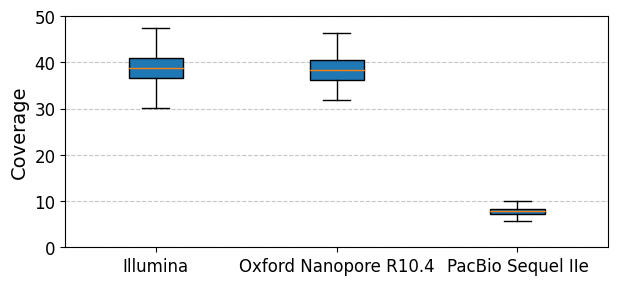

In [51]:
import matplotlib.pyplot as plt

# Creating the box-and-whisker plot
data = [sr_metrics.mean_coverage.tolist(), ont_metrics.mean_coverage.tolist(), lr_metrics.mosdepth_cov.tolist()]
labels = ['Illumina', 'Oxford Nanopore R10.4', 'PacBio Sequel IIe']

#data = [lr_metrics.mosdepth_cov.tolist(), ont_metrics.mean_coverage.tolist(), sr_metrics.mean_coverage.tolist()]
#labels = ['PacBio Sequel IIe', 'Oxford Nanopore R10.4', 'Illumina']


plt.figure(figsize=(7, 3))
plt.boxplot(data, labels=labels, patch_artist=True, showfliers=False)
#plt.title('Coverage Metrics')
plt.ylabel('Coverage', fontsize=14)
#plt.ylabel('Sequencing Platform', fontsize=14)
plt.ylim(0, 50)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("coverage_metrics_boxplot.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [52]:
[int(x) for x in sr_read_lengths]

[151]

In [53]:
lr_metrics.aligned_read_length_mean.tolist()

[17021.8,
 15608.5,
 18098.0,
 18384.7,
 20242.1,
 17961.5,
 17232.3,
 17789.0,
 17628.6,
 17739.4,
 20418.9,
 16857.8,
 15800.5,
 16940.3,
 16694.6,
 17524.8,
 17576.4,
 18719.4,
 16773.0,
 17280.5,
 16217.3,
 16839.3,
 16194.9,
 17273.5,
 17209.7,
 16215.8,
 19335.1,
 17182.9,
 16077.3,
 18161.8,
 16705.7,
 17535.4,
 17540.5,
 16793.7,
 19083.8,
 16618.4,
 17932.7,
 17463.1,
 15002.6,
 17920.3,
 17262.5,
 17356.9,
 17516.5,
 17699.0,
 18695.4,
 16521.2,
 19271.2,
 19160.5,
 16851.6,
 17156.3,
 18151.3,
 17067.7,
 18255.8,
 17090.6,
 17031.3,
 15909.8,
 15992.3,
 17027.8,
 15855.5,
 18685.5,
 15550.1,
 15927.0,
 19565.2,
 17693.4,
 18037.4,
 18799.6,
 17142.6,
 16665.7,
 18371.8,
 18196.8,
 17618.9,
 17871.8,
 15772.3,
 18306.0,
 19513.3,
 17375.0,
 15409.4,
 16938.5,
 17183.1,
 17748.3,
 17035.6,
 16970.8,
 16783.4,
 18716.5,
 17288.8,
 16974.7,
 15062.4,
 17083.6,
 17680.7,
 18558.0,
 17581.7,
 16959.3,
 17712.7,
 18546.4,
 17512.1,
 15220.4,
 17620.9,
 18906.4,
 18018.1,
 17738.5,


In [54]:
f['alignment_metrics'].apply(lambda x: ast.literal_eval(x)).apply(pd.Series)['median_read_length'].tolist()

[16283.0,
 14566.0,
 14677.0,
 13626.0,
 14337.0,
 13877.0,
 15315.0,
 16359.0,
 14736.0,
 15657.5,
 15734.0,
 14197.0,
 15062.5,
 14920.0,
 15331.0,
 16087.0,
 15365.0,
 14354.0,
 15277.0,
 13433.0,
 14422.0,
 14759.0,
 15907.0,
 15564.0,
 15369.0,
 15762.0,
 14051.0,
 15269.0,
 15086.0,
 13503.0,
 14459.0,
 14573.0,
 14961.0,
 14931.0,
 13914.0,
 15126.0,
 16113.0,
 14661.0,
 15105.0,
 15440.0,
 13524.0,
 14413.0,
 14028.0,
 14214.0,
 14808.0,
 13945.0,
 16281.0,
 13549.0,
 15740.0,
 14685.0]

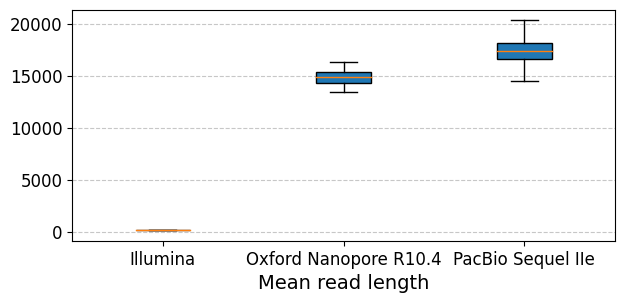

In [55]:
import matplotlib.pyplot as plt

data = [[int(x) for x in sr_read_lengths], f['alignment_metrics'].apply(lambda x: ast.literal_eval(x)).apply(pd.Series)['median_read_length'].tolist(), lr_metrics.aligned_read_length_mean.tolist()]
labels = ['Illumina', 'Oxford Nanopore R10.4', 'PacBio Sequel IIe']

#data = [lr_metrics.aligned_read_length_mean.tolist(), f['alignment_metrics'].apply(lambda x: ast.literal_eval(x)).apply(pd.Series)['median_read_length'].tolist(), [int(x) for x in sr_read_lengths]]
#labels = ['PacBio Sequel IIe', 'Oxford Nanopore R10.4', 'Illumina']

plt.figure(figsize=(7, 3))
plt.boxplot(data, labels=labels, patch_artist=True, showfliers=False)
#plt.title('Coverage Metrics')
plt.xlabel('Mean read length', fontsize=14)
#plt.ylabel('Sequencing Platform', fontsize=14)
#plt.xlim(0, 50)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("coverage_metrics_boxplot.pdf", format="pdf", bbox_inches="tight")

plt.show()

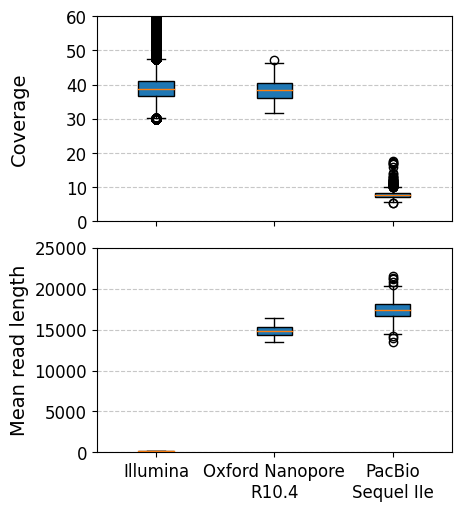

In [56]:
import matplotlib.pyplot as plt

labels = ['Illumina', 'Oxford Nanopore\nR10.4', 'PacBio\nSequel IIe']

cov_data = [sr_metrics.mean_coverage.tolist(), ont_metrics.mean_coverage.tolist(), lr_metrics.mosdepth_cov.tolist()]
rl_data = [[int(x) for x in sr_read_lengths], f['alignment_metrics'].apply(lambda x: ast.literal_eval(x)).apply(pd.Series)['median_read_length'].tolist(), lr_metrics.aligned_read_length_mean.tolist()]

fig, axs = plt.subplots(2, 1, figsize=(4.5, 5), constrained_layout=True)

axs[0].boxplot(cov_data, labels=['', '', ''], patch_artist=True, showfliers=True)
axs[0].set_ylabel('Coverage', fontsize=14)
axs[0].set_ylim(0, 60)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

axs[1].boxplot(rl_data, labels=labels, patch_artist=True, showfliers=True)
axs[1].set_ylabel('Mean read length', fontsize=14)
axs[1].set_ylim(0, 25000)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

fig.align_ylabels(axs)

plt.savefig("metrics_boxplot.pdf", format="pdf", bbox_inches="tight")

plt.show()

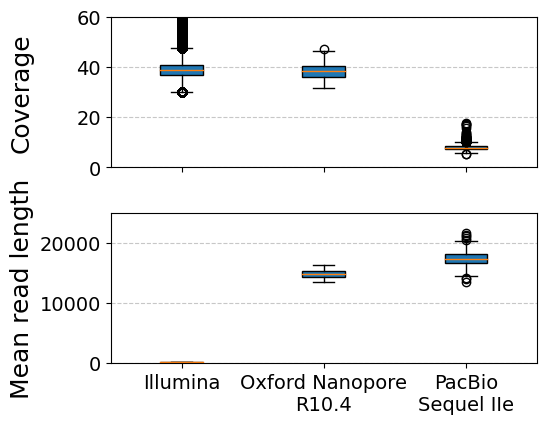

In [67]:
import matplotlib.pyplot as plt

labels = ['Illumina', 'Oxford Nanopore\nR10.4', 'PacBio\nSequel IIe']

cov_data = [
    sr_metrics.mean_coverage.tolist(),
    ont_metrics.mean_coverage.tolist(),
    lr_metrics.mosdepth_cov.tolist()
]

rl_data = [
    [int(x) for x in sr_read_lengths],
    f['alignment_metrics'].apply(lambda x: ast.literal_eval(x)).apply(pd.Series)['median_read_length'].tolist(),
    lr_metrics.aligned_read_length_mean.tolist()
]

# Slightly reduce vertical space and overall margins
fig, axs = plt.subplots(2, 1, figsize=(5.5, 4.5), gridspec_kw={'hspace': 0.3})

axs[0].boxplot(cov_data, labels=['', '', ''], patch_artist=True, showfliers=True)
axs[0].set_ylabel('Coverage', fontsize=18)
axs[0].set_ylim(0, 60)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

axs[1].boxplot(rl_data, labels=labels, patch_artist=True, showfliers=True)
axs[1].set_ylabel('Mean read length', fontsize=18)
axs[1].set_ylim(0, 25000)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

fig.align_ylabels(axs)

# Save with tight bounding box to trim whitespace
plt.savefig("metrics_boxplot.pdf", format="pdf", bbox_inches="tight", pad_inches=0.01)

plt.show()